In [1]:
#import libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
%matplotlib inline
import seaborn
plt.style.use('seaborn')#switch to seaborn style# TODO
seaborn.set_style(style='white')

In [3]:
tracks = pd.read_csv('data/tracks.csv', index_col=0, header=[0, 1]);
#load and normalize features
features= pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
dfmax=abs(features).max()
features=features.divide(dfmax)

genres=pd.read_csv('data/genres.csv', index_col=0, header=[0])


In [4]:
# Keep only the genre for each track
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top'],
                    ('label','genre','sub'): tracks['track']['genres']})

# Keep on the tracks from small subset
label = label[tracks['set','subset'] == 'small']


# Keep only the genres we want
genre_list = ['Hip-Hop','Rock','Folk']#['Hip-Hop', 'Rock','Jazz','Classical','Pop','Electronic']
label = label[label['label']['genre']['main'].isin(genre_list)]

#add sub genres
genres_dict=genres['title'].to_dict()
genres_dict={str(key):genres_dict[key] for key in genres_dict}

label['label']['genre']['sub']=label['label']['genre']['sub'].str.replace('[^0-9| ]','').str.split(' ').apply(lambda x:'|'.join([genres_dict[k] for k in x ]))


# Merging
dataSet = features.merge(label, left_index=True, right_on='track_id')
#dataSet=dataSet.sort_values([('label', 'genre','main')])


In [5]:
print(sum(dataSet.label.genre.main=='Instrumental'))
label.label.genre.main.unique()

0


array(['Hip-Hop', 'Folk', 'Rock'], dtype=object)

In [6]:
#we calculate the distances of our dataset
distances = pdist(dataSet.drop(columns='label',level=0).values, metric='euclidean')

In [7]:
#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)

In [8]:
np.save("data/adjacency_HRJC.npy",adjacency_full)

In [9]:
adjacency_full=np.load("data/adjacency_HRJC.npy")

In [10]:
# plt.hist(weights)
# plt.title('Distribution of weights')
# plt.xlabel('Weights of links')
# plt.show()

In [11]:
#informatons over connectivity of main component 
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.65] = 0
graph=nx.from_numpy_matrix(adjacency)
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=sorted(nx.connected_components(graph), key = len, reverse=True)
print("#nodes in giant component= ", len(list_comp[0]))
print("percentage of nodes in main component= ",len(list_comp[0])/adjacency.shape[0])

#nodes=  3000
#compo=  465
#nodes in giant component=  2512
percentage of nodes in main component=  0.8373333333333334


In [12]:
# list(nx.connected_component_subgraphs(graph))[0].node

In [13]:
#keep only the main component and corresponding label
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
conn_label=label.iloc[list(list_comp[0])]

## Graph plot##

In [14]:
laplacian=nx.laplacian_matrix(conn_graph)

In [15]:
label=np.array(conn_label.label.genre.main)
label_num=label.copy()
label_num[label_num=='Hip-Hop']=-1
label_num[label_num=='Rock']=-0.3333
label_num[label_num=='Folk']=0.3333
label_num[label_num=='Pop']=1
label_num

array([-1, -1, 0.3333, ..., -1, 0.3333, -1], dtype=object)

In [16]:
e,eigenvectors = scipy.sparse.linalg.eigs(laplacian,k=6)

e=e.real
eigenvectors=eigenvectors.real

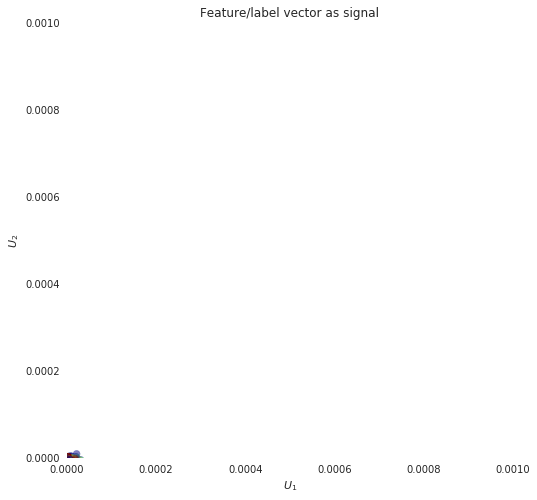

In [17]:
#using laplacian eigenmap
plt.figure(figsize=(8, 8))

plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], alpha=0.5, cmap='jet', c=label_num)
plt.title('Feature/label vector as signal')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.xlim([0,0.001])
plt.ylim([0,0.001])
plt.show()

In [18]:
#using springlayout
coords = nx.spring_layout(conn_graph)  # Force-directed layout.

In [19]:
i=0
coords_x=[]
coords_y=[]
for i in (conn_graph.node):
    coords_x.append(coords[i][0])
    coords_y.append(coords[i][1]);   
    i+=1;
    

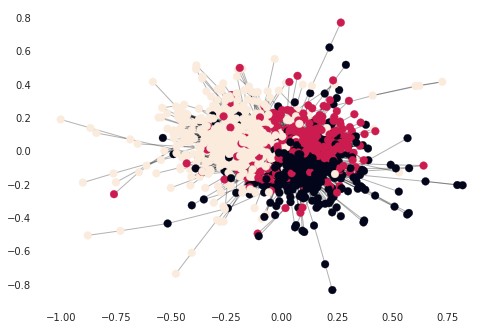

In [20]:
# np.save('data/coords_HRJC',coords)
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20, 15))

# ax = fig.add_subplot(221, projection='3d')
# ax_c=ax.scatter(coords_x,coords_y, label_num, c=label_num,cmap="coolwarm")
# plt.colorbar(ax_c)
# fig.colorbar
# ax.set_title("Signal")

nx.draw_networkx_nodes(conn_graph, coords, node_size=60, node_color=label_num)
nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)

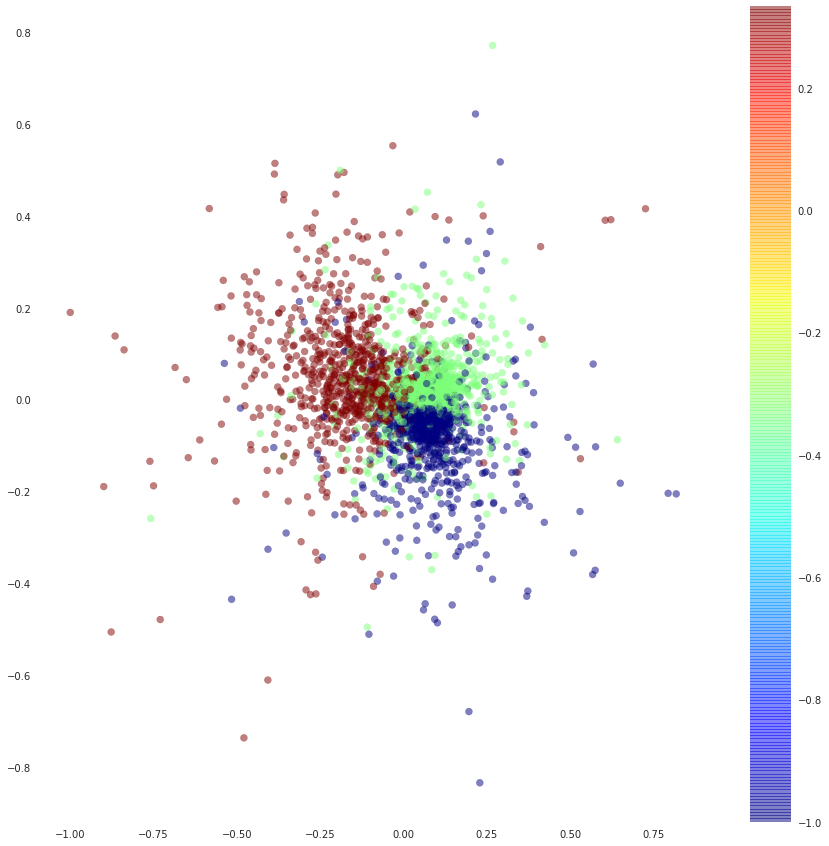

In [21]:
plt.figure(figsize=(15, 15))

plt.scatter(coords_x,coords_y,c=label_num , alpha=0.5, cmap='jet')

plt.colorbar()
plt.show()

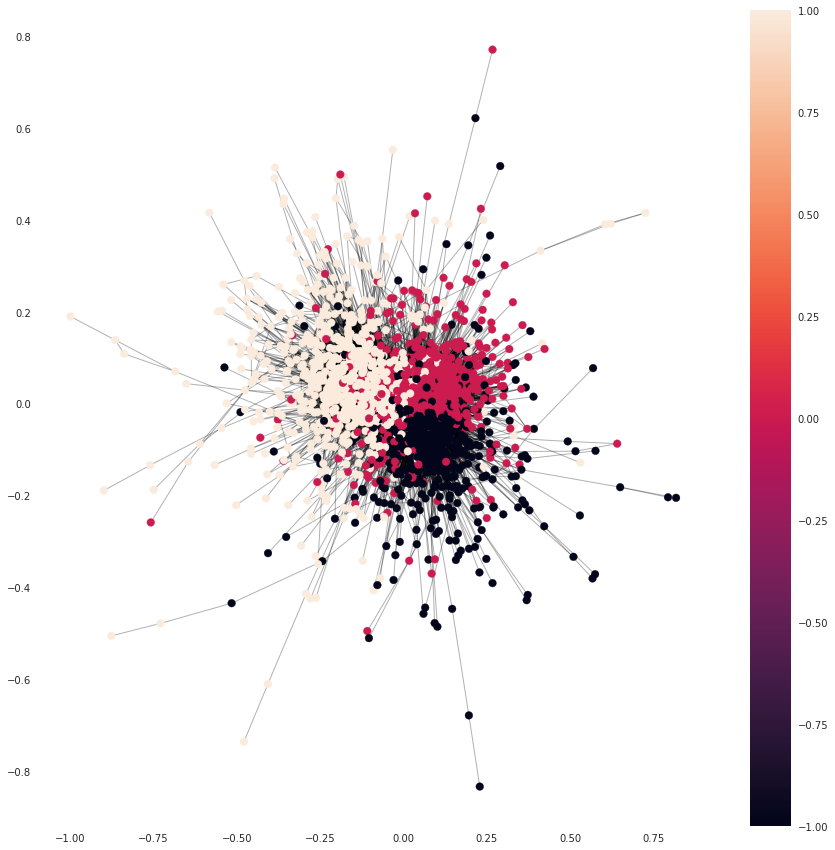

In [22]:
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(conn_graph, coords,node_size=60, node_color=label_num)
nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
plt.colorbar(sm)
plt.show()

In [23]:
tmp_label=list(np.array(conn_label.label.genre.main))

i=0;
node_dict=dict()
for n in conn_graph.node:
    node_dict[n]=i
    i+=1;
conn_graph_rename=nx.relabel_nodes(conn_graph,node_dict)

label_dict={i : tmp_label[i] for i in range(len(conn_graph.node))}
    
nx.set_node_attributes(conn_graph_rename, values=label_dict, name="genre")

In [24]:
# import random
# subnode=random.sample(list(conn_graph.node), 5000)
# sub_graph=conn_graph.subgraph(subnode)
nx.write_gexf(conn_graph_rename, "data/graph_small_HRFP.gexf")

In [25]:
conn_graph_rename.node

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

---
# personal tests

## Load custom track

In [26]:
# For custom audio files
features_c = pd.read_csv('data/custom_features.csv', index_col=0, header=[0, 1, 2], sep=',', encoding='utf-8')
tid_c = pd.read_csv('data/custom_tid.csv', index_col=0, header=[0], sep=',', encoding='utf-8')

dfmax=abs(features_c).max()
features_c=features_c.divide(dfmax)

In [27]:
display(features_c)
display(tid_c)

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
-1            0.542253  0.543757  0.550152  1.000000  1.000000  1.000000   
-2            1.000000  1.000000  1.000000 -0.129357 -0.320601 -0.041011   

feature                                               ...      tonnetz  \
statistics                                            ...          std   
number            07        08        09        10    ...           04   
track_id                                              ...                
-1          1.000000  1.000000  1.000000  1.000000    ...     0.623345   
-2          0.391457  0.238876  0.019296 -0.114005    ...     1.000000   

feature                              zcr                                    \
statistics                      kurtosis       max      mean    median min   
number            05        06        01        01        01        01  01   
track_id                                                                     
-1          0.762747  0.797521  0.412255  1.000000  1.000000  1.000000 NaN   
-2          1.000000  1.000000  1.000000  0.646937  0.450354  0.428058 NaN   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
-1          0.295918  1.000000  
-2          1.000000  0.663735  

[2 rows x 518 columns]

,Song name
Track ID,
-1,IOT
-2,Tenacious D
